# 코랩 구글 드라이브 연동

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 파이썬 라이브러리 불러오기

In [2]:
%matplotlib inline
import torchvision
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import torchvision.utils
import numpy as np
import random
from PIL import Image
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
from tkinter import *
import imutils
import cv2
from PIL import Image, ImageTk
import os
import time

# 샴 네트워크 모델
파라미터를 공유하는 CNN을 사용함

In [4]:
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()

        self.cnn1 = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(1, 4, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(4),

            nn.ReflectionPad2d(1),
            nn.Conv2d(4, 8, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),

            nn.ReflectionPad2d(1),
            nn.Conv2d(8, 8, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),
        )
        self.fc1 = nn.Sequential(
            nn.Linear(8*100*100, 500),
            nn.ReLU(inplace=True),
            nn.Linear(500, 500),
            nn.ReLU(inplace=True),
            nn.Linear(500, 250),
            nn.ReLU(inplace=True),
            nn.Linear(250, 15)
        )


    def forward(self, input):
        x = self.cnn1(input)
        x = x.view(x.size()[0], -1)
        x = self.fc1(x)
        return x

# 손실 함수 (Contrastive Loss)
margin값을 적절하게 주는 것이 중요

In [5]:
class ContrastiveLoss(nn.Module):
    def __init__(self):
        super(ContrastiveLoss, self).__init__()
        self.pos_margin = 20.0
        self.neg_margin = 100.0

    def forward(self, output1, output2, label):
        dist = F.pairwise_distance(output1, output2, keepdim = True)  # CNN 결과의 유클리드 거리를 계산

        loss = torch.mean(
            (1 - label) * torch.pow(torch.clamp(dist - self.pos_margin, min=0.0), 2)  # 같은 클래스의 거리가 pos_margin 보다 작도록 학습
            + (label) * torch.pow(torch.clamp(self.neg_margin - dist, min=0.0), 2)  # 다른 클래스의 거리가 neg_margin 이상이 되도록 학습
        )

        return loss

# 커스텀 데이터셋 만들기
한 쌍의 이미지를 랜덤하게 선택

In [6]:
class SiameseDataset(Dataset):
    def __init__(self, img_dataset, transform=None):
        self.img_dataset = img_dataset
        self.transform = transform
        self.length = range(len(self.img_dataset))
        self.t = img_dataset.targets

    def __getitem__(self, idx):
        # 데이터셋에서 첫 번째 데이터를 가져옴
        img0_tuple = self.img_dataset.imgs[idx]
        fi = self.t.index(img0_tuple[1])
        li = len(self.t) - self.t[::-1].index(img0_tuple[1])

        # 데이터셋에서 두 번째 데이터를 가져옴, 50% 확률로 첫 번째와 동일한 클래스
        same_class = random.randint(0, 1)
        if same_class:
            idx2 = [x for x in self.length if x != idx and fi <= x < li]  # 같은 클래스의 랜덤한 인덱스
        else:
            idx2 = [x for x in self.length if x < fi or x >= li]  # 다른 클래스의 랜덤한 인덱스
        img1_tuple = self.img_dataset.imgs[random.choice(idx2)]

        # 이미지 파일 열기
        img0 = Image.open(img0_tuple[0])
        img1 = Image.open(img1_tuple[0])

        # 이미지 전처리 및 증강
        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)

        return img0, img1, torch.FloatTensor([same_class^1])

    def __len__(self):
        return len(self.img_dataset)

# 이미지 시각화 함수 (imshow)

In [7]:
def imshow(img, figsize=(4, 2)):
    plt.figure(figsize=figsize)
    npimg = img.numpy()
    plt.axis("off")
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# 데이터 불러오기

In [ ]:
# 학습 데이터
train_dir = "/content/drive/MyDrive/Facial-Similarity-with-Siamese-Networks-in-Pytorch/data/faces/training"
img_dataset = ImageFolder(train_dir)

# 샴 네트워크 학습을 위한 커스텀 데이터셋
train_dataset = SiameseDataset(
    img_dataset=img_dataset,
    transform=transforms.Compose([
        transforms.Grayscale(),
        transforms.RandomAffine(degrees=10, shear=5),  # 이미지 증강 - 무작위로 회전 및 기울임
        transforms.Resize((100, 100)),
        transforms.ToTensor()
    ])
)

train_loader = DataLoader(
    train_dataset,
    shuffle=True,
    num_workers=8,
    batch_size=64
)

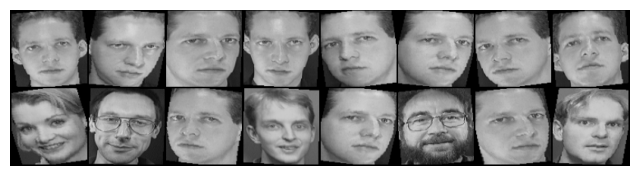

[1. 1. 0. 1. 0. 1. 0. 1.]


In [10]:
# 학습 데이터 시각화
example_loader = DataLoader(
    train_dataset,
    # shuffle=True,
    num_workers=8,
    batch_size=8
)

example_batch = next(iter(example_loader))
concat = torch.cat((example_batch[0],example_batch[1]),0)
imshow(torchvision.utils.make_grid(concat), figsize=(8, 4))
print(example_batch[2].view(-1).numpy())  # 0 = 같은 클래스  # 1 = 다른 클래스

1 1 0


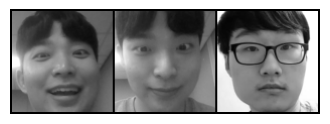

In [11]:
# 테스트 데이터
test_dir = "/content/drive/MyDrive/test2"
test_dataset = ImageFolder(
    root=test_dir,
    transform=transforms.Compose([
        transforms.Grayscale(),
        transforms.Resize((100,100)),
        transforms.ToTensor()
    ])
)
test_loader = DataLoader(test_dataset)

# 정확도를 확인하기 위한 테스트 데이터
# test_img0과 test_img1은 같은 클래스
# test_img0과 test_img2는 다른 클래스
test_img0, label0 = test_dataset[6]
test_img1, label1 = test_dataset[7]
test_img2, label2 = test_dataset[3]
test_img0, test_img1, test_img2 = test_img0.unsqueeze(0), test_img1.unsqueeze(0), test_img2.unsqueeze(0)

# 테스트 데이터 시각화
print(label0, label1, label2)
concat = torch.cat((test_img0, test_img1, test_img2), 0)
imshow(torchvision.utils.make_grid(concat))

test_img0, test_img1, test_img2 = test_img0.to(device), test_img1.to(device), test_img2.to(device)

# test_dataset.imgs

# 모델 학습

In [12]:
model = SiameseNetwork().to(device)
loss_func = ContrastiveLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.00002 )

epoch_counter = []
loss_history = []
dist_history_p = []
dist_history_n = []
counter = 0
batches = len(train_loader)

In [19]:
for epoch in range(200):
    counter += 1
    loss_sum = 0.0
    for i, data in enumerate(train_loader):
        img0, img1, label = data
        img0, img1, label = img0.to(device), img1.to(device), label.to(device)
        # 모델 학습
        optimizer.zero_grad()
        output1 = model(img0)
        output2 = model(img1)
        loss = loss_func(output1,output2,label)
        loss.backward()
        optimizer.step()

        if counter % 5 == 0:
            loss_sum += loss.item()

    # 5번 마다 학습 결과를 저장함
    if counter % 5 == 0:
        loss_avg = loss_sum / batches
        epoch_counter.append(counter)  # epoch
        loss_history.append(loss_avg)  # 평균 loss
        print(f"\nEpoch: {counter}\t\tLoss: {loss_avg}")

        # 테스트 데이터 간의 CNN 결과의 거리를 계산
        model.eval()
        with torch.no_grad():
            test_output0 = model(test_img0)
            test_output1 = model(test_img1)
            test_output2 = model(test_img2)
        model.train()

        test_dist_p = F.pairwise_distance(test_output0, test_output1)
        test_dist_n = F.pairwise_distance(test_output0, test_output2)
        dist_history_p.append(test_dist_p.item())  # 같은 클래스의 거리
        dist_history_n.append(test_dist_n.item())  # 다른 클래스의 거리
        print(f"pos: {test_dist_p.item():.5f}\t\tneg: {test_dist_n.item():.5f}")



Epoch: 605		Loss: 2.5144176880518594
pos: 69.87033		neg: 161.59694

Epoch: 610		Loss: 2.594057192405065
pos: 71.91839		neg: 162.64867

Epoch: 615		Loss: 1.8268565957744916
pos: 70.02055		neg: 165.18163

Epoch: 620		Loss: 2.638046453396479
pos: 69.17470		neg: 164.09265

Epoch: 625		Loss: 1.3585874993974965
pos: 70.22638		neg: 162.43028

Epoch: 630		Loss: 0.6874830250938734
pos: 72.52373		neg: 163.59456

Epoch: 635		Loss: 1.5710111806790035
pos: 73.89310		neg: 164.31828

Epoch: 640		Loss: 4.361503993471463
pos: 73.05324		neg: 167.22066

Epoch: 645		Loss: 1.2271303286155064
pos: 72.31199		neg: 165.51018

Epoch: 650		Loss: 0.6446888695160548
pos: 70.39292		neg: 163.15143

Epoch: 655		Loss: 1.4393295819560687
pos: 70.26048		neg: 164.27820

Epoch: 660		Loss: 1.9617698583751917
pos: 71.04793		neg: 163.04774

Epoch: 665		Loss: 0.5003812611103058
pos: 73.78474		neg: 165.40874

Epoch: 670		Loss: 0.7507763107617696
pos: 72.38958		neg: 165.08548

Epoch: 675		Loss: 0.45677150429340446
pos: 73.2587

# 학습 결과 확인


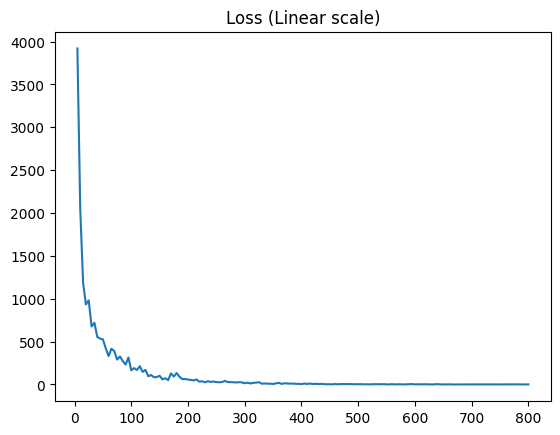

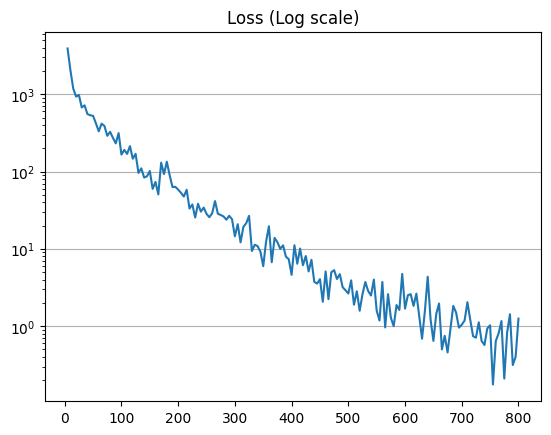

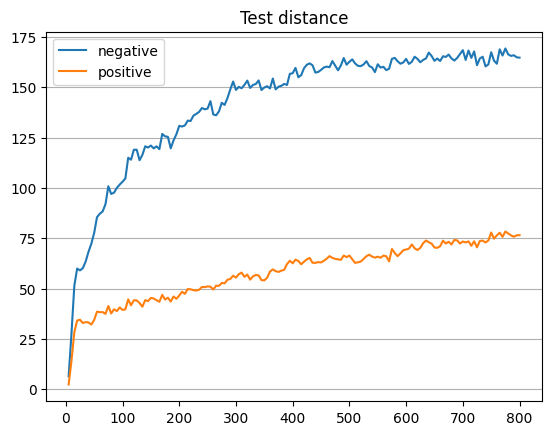

In [20]:
plt.title('Loss (Linear scale)')
plt.plot(epoch_counter, loss_history)
plt.show()

plt.title('Loss (Log scale)')
plt.semilogy(epoch_counter,loss_history)
plt.grid(True, axis='y')
plt.show()

plt.title('Test distance')
plt.plot(epoch_counter, dist_history_n, label='negative')
plt.plot(epoch_counter, dist_history_p, label='positive')
plt.grid(True, axis='y')
plt.legend()
plt.show()

In [21]:
# 모든 테스트 데이터의 CNN 결과를 계산하고 저장함
classes = test_dataset.classes
test_list = []
model.eval()
with torch.no_grad():
    for img, label in test_loader:
        output = model(img.to(device))
        test_list.append([output, label])
model.train()

# 모든 테스트 데이터 사이의 거리를 계산함
# 행 = 클래스의 개수 / 열 = 각 클래스의 이미지 개수
# ex) 1행 n열의 숫자가 0일 때, 1행의 숫자들은 margin보다 작아야 하고 다른 행의 숫자들은 margin보다 커야 함
for idx, i in enumerate(test_list):
    print('\n=====================', idx , '=====================')
    k = 0
    for j in test_list:
        if j[1] == k:
            if k:
                print('')
            print(f'{classes[k]:10s}', end='\t')
            k += 1
        print(int(F.pairwise_distance(i[0], j[0]).item()), end='\t')
    print('')


===================== 0 =====================
BHM       	0	35	2	19	
JYT       	150	187	177	130	159	
SYJ       	146	182	211	183	

===================== 1 =====================
BHM       	35	0	33	18	
JYT       	123	156	148	102	131	
SYJ       	135	164	191	158	

===================== 2 =====================
BHM       	2	33	0	16	
JYT       	149	186	176	129	158	
SYJ       	145	181	210	181	

===================== 3 =====================
BHM       	19	18	16	0	
JYT       	139	173	164	118	148	
SYJ       	138	172	200	169	

===================== 4 =====================
BHM       	150	123	149	139	
JYT       	0	62	61	31	19	
SYJ       	190	192	203	171	

===================== 5 =====================
BHM       	187	156	186	173	
JYT       	62	0	25	75	47	
SYJ       	185	172	174	142	

===================== 6 =====================
BHM       	177	148	176	164	
JYT       	61	25	0	76	43	
SYJ       	170	158	160	133	

===================== 7 =====================
BHM       	130	102	129	118	
JYT       	31	75	76	

# 모델 저장하기 및 불러오기

In [22]:
# torch.save(model.state_dict(), 'model3.pth')
# model.load_state_dict(torch.load("/content/drive/MyDrive/model3.pth", map_location=device))